<a href="https://colab.research.google.com/github/Umutoniwasepie/Sound_Dataset_Clustering/blob/main/Clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:

#Make allNecessary Imports
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive


In [2]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/Colab Notebooks/Sound_Clustering/unlabelled_sounds"

# Function to extract Mel Spectrogram features
def extract_features(file_path):
    """Extract Mel Spectrogram features from a single audio file."""
    y, sr = librosa.load(file_path, sr=None)
    n_fft = min(2048, len(y))  # Adjusted n_fft to fit the audio length, avoiding warnings
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return np.mean(mel_spec_db, axis=1)  # Mean across time for a feature vector

# Extract Features from all the files
features = []
audio_file_list = []

drive.mount('/content/drive')
for file in os.listdir(unlabelled_data_path):
    if file.endswith(".wav"):
        file_path = os.path.join(unlabelled_data_path, file)
        feature = extract_features(file_path)
        features.append(feature)
        audio_file_list.append(file)

features_array = np.array(features)
print(f"Extracted features shape: {features_array.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted features shape: (3000, 128)


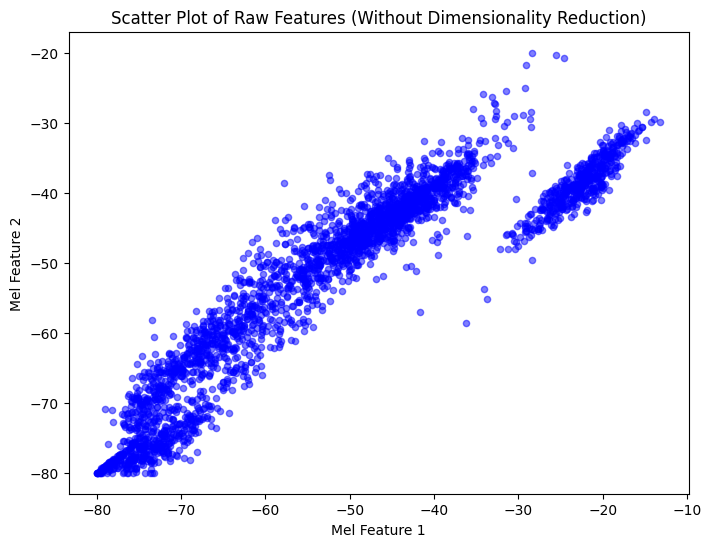

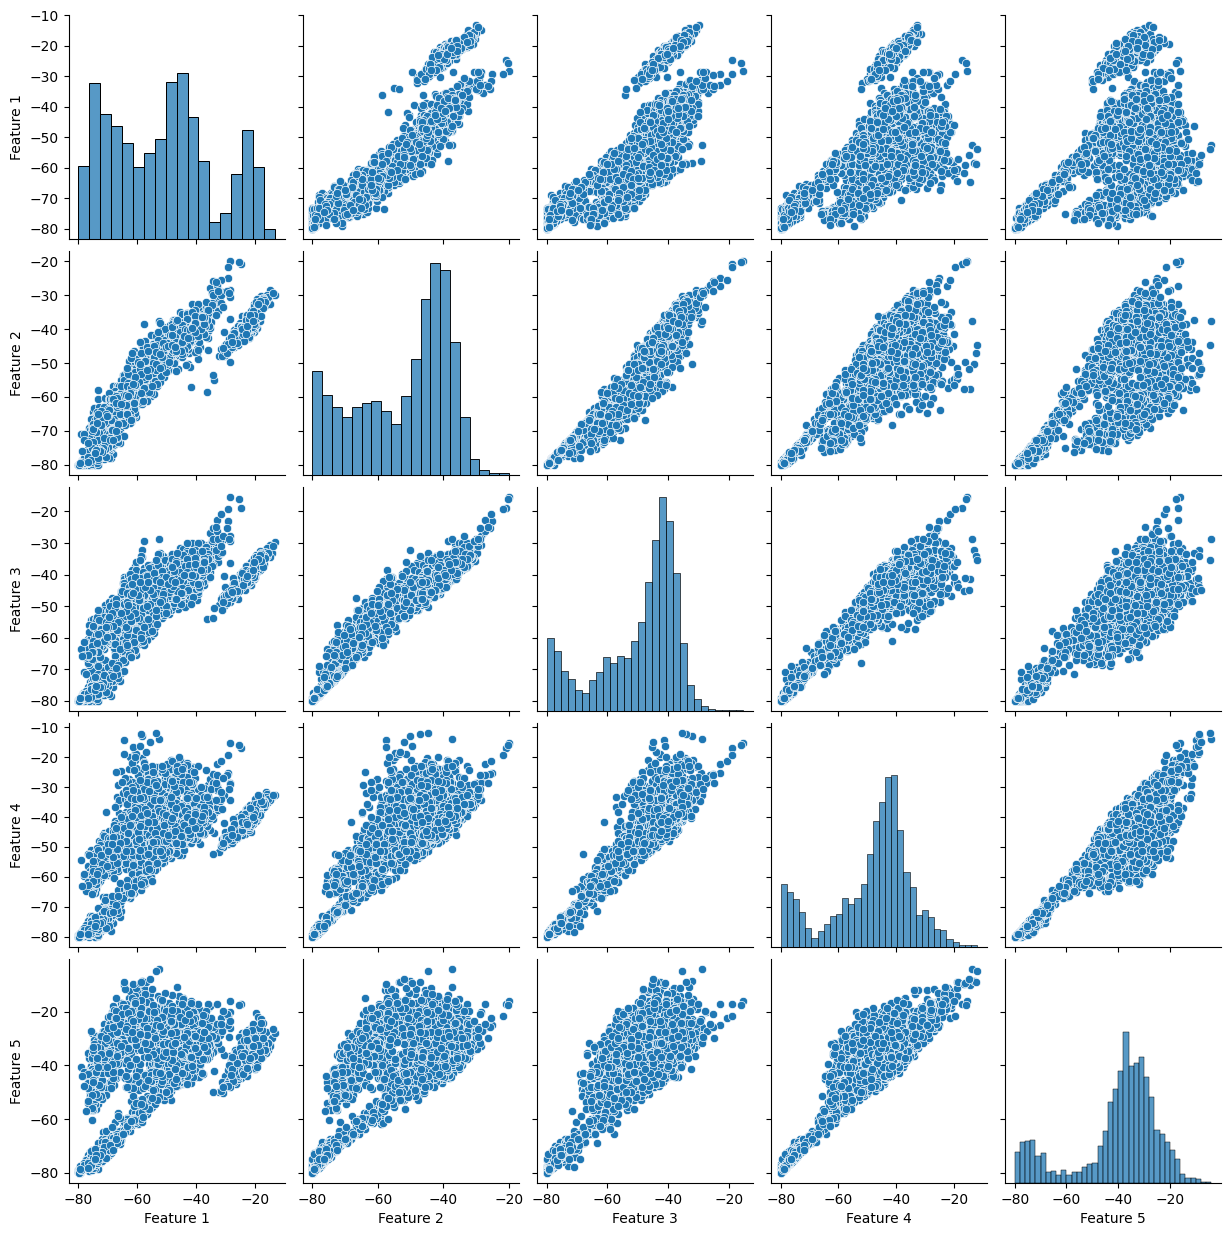

CPU times: user 5.11 s, sys: 384 ms, total: 5.5 s
Wall time: 5.16 s


In [12]:
%%time
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.5, c='blue', s=20)
plt.xlabel("Mel Feature 1")
plt.ylabel("Mel Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (First 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?

When I tried visualizing the 128-dimensional Mel spectrogram features from our 3000 audio files. it presented some challenges. The scatter plot of the first two features displayed a dense and overlapping distribution with two elongated clusters, which made it difficult for me to understand patterns from the other 126 dimensions.

Then, the pair plot for the first five features became even trickier, it made a grid of cluttered scatter plot, and the histograms are uneven, which makes it hard to ssee/view any meaningful trends.
All these challenges shows that with so many dimensions, the data gets noisy, redundant, and confusing, which is why dimensionality reduction is necessary.

It helps distill the data into a lower-dimensional representation, preserving key structures while enabling effective visualization and clustering.



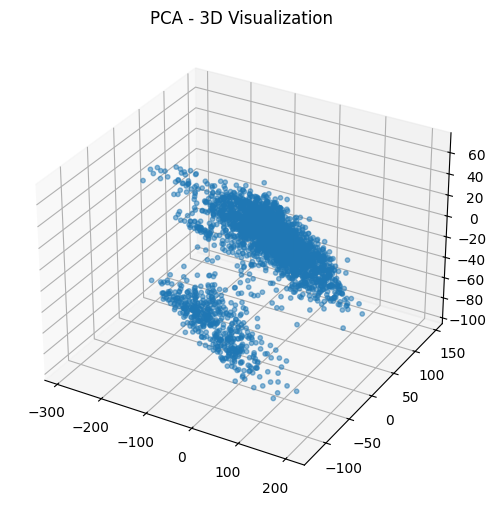

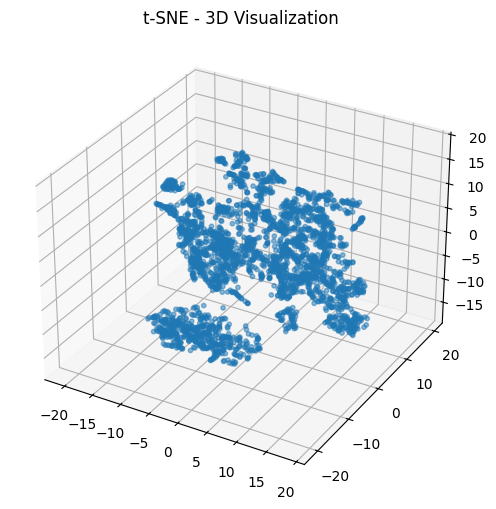

In [13]:
# Apply PCA (3 components)
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.5, s=10)
ax.set_title("PCA - 3D Visualization")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.5, s=10)
ax.set_title("t-SNE - 3D Visualization")
plt.show()

### Which method (PCA or t-SNE) provides better separability of clusters and why?

Based on the 3D visualizations, t-SNE demonstrates superior cluster separability compared to PCA. The t-SNE plot reveals distinct, compact clusters that suggest a meaningful grouping of audio features, reflecting the underlying data structure. In contrast, the PCA plot displays a more dispersed distribution with two prominent, overlapping clusters, indicating limited clarity in defining separate groups. This difference arises because t-SNE effectively preserves local relationships between data points, which aligns with the complex patterns in our audio data, whereas PCA focuses on global variance and may overlook finer cluster boundaries.





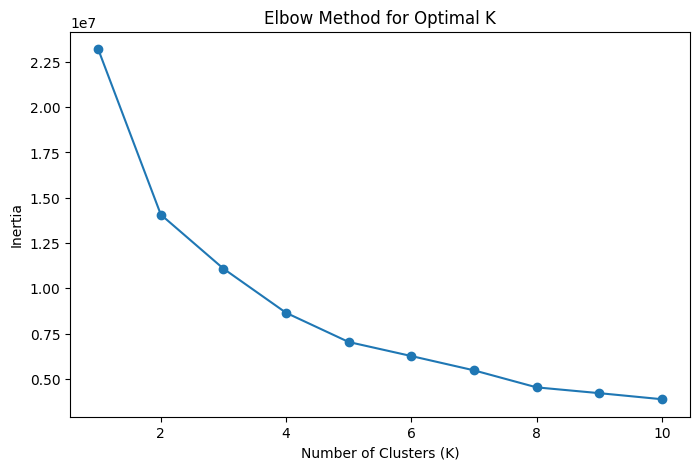

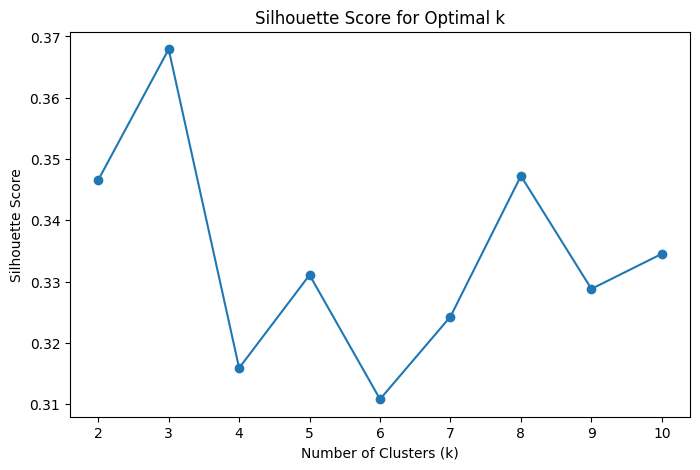

In [14]:
# Optimize number of clusters using Elbow Method
inertia = []  # Stores inertia for each K value
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Optimize using Silhouette Score
silhouette_scores = []
for k in range(2, 11):  # Silhouette requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    score = silhouette_score(features_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")
plt.show()

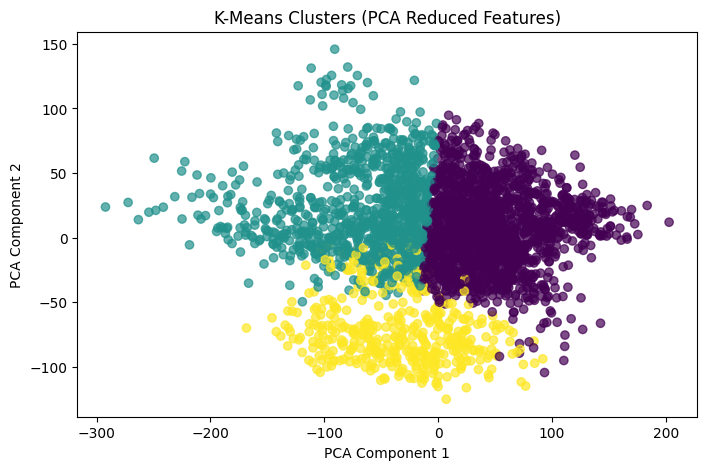

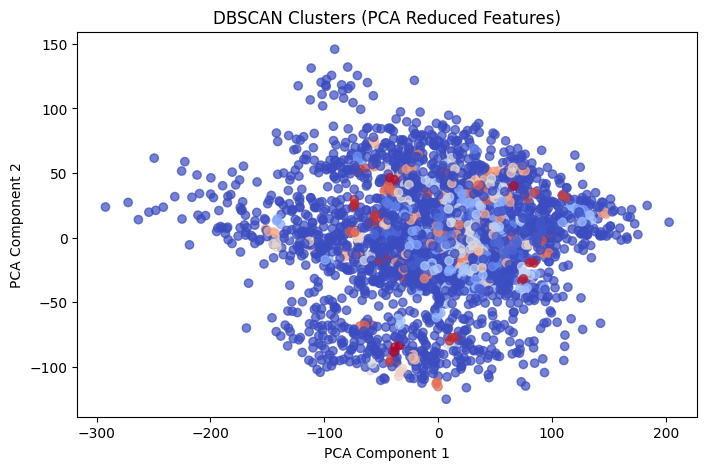

In [22]:
# Select optimal K based on elbow and silhouette
optimal_k = 3  # Elbow at 3-4, silhouette peaks near 3, so let’s continue with 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_pca)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clusters (PCA Reduced Features)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8, 5))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clusters (PCA Reduced Features)")
plt.show()

In [23]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)
kmeans_inertia = kmeans.inertia_

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}, Inertia: {kmeans_inertia:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3679, Davies-Bouldin Index: 1.0441, Inertia: 11082363.0000
DBSCAN - Silhouette Score: -0.4315, Davies-Bouldin Index: 1.6339


### Discuss the results (max 5 lines)

K-Means with k=3 delivered an excellent silhouette score of 0.3679, a good Davies-Bouldin index of 1.0441, and a reasonable inertia, showing tight, well-separated clusters. On the other hand, DBSCAN bombed with a bad -0.4315 silhouette and a poor 1.6339 Davies-Bouldin, still lost in noise which I think is probably because of its strict settings.
This makes k=3, backed by the silhouette peak, the clear winner.





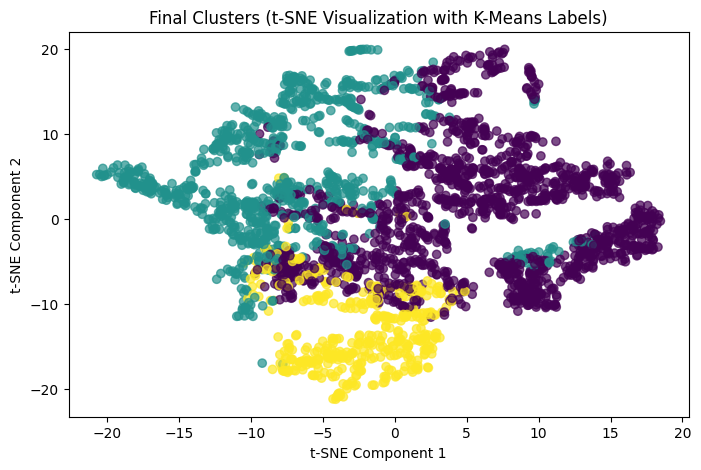

In [17]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

- Explain why dimensionality reduction helped (or didn’t) in clustering:

Dimensionality reduction really helped, especially with t-SNE. Dropping the 128 dimensions down to 3 helped uncover the tighter clusters we saw, which K-Means (k =3) captured nicely. PCA spread things out too much, so it didn’t help as much, but t-SNE’s focus on keeping local patterns intact made a big difference for clustering.


- Justify why certain clustering methods worked better:

K-Means shone because we tuned it with the elbow method and silhouette score(about 0.37), landing on k=3, which fit the data’s natural groups. DBSCAN struggled, though—its default settings were too harsh, turning most points into noise. The data’s shape just didn’t play nice with DBSCAN’s density approach this time.


- Relate findings to real-world clustering challenges:

A real-world example is sorting audio clips, where too many features can blur the lines. t-SNE’s ability to preserve structure made clustering smoother, and K-Means handled our neat clusters well. DBSCAN’s struggle shows density methods need tuning for less uniform data, a common hurdle in practice.



